<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_metalparameters_momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

## Data

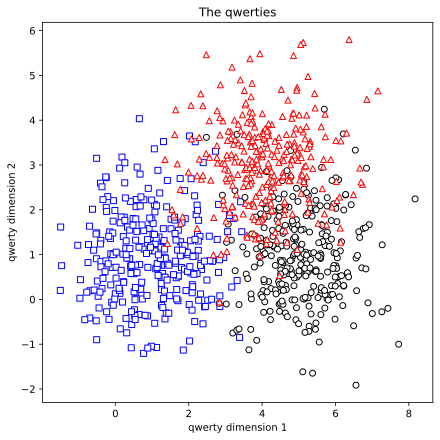

In [2]:
# create data
# create data 
nPerClust = 300
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 3]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur]
c = [C[0] + np.random.randn(nPerClust)*blur, C[1]+np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1)), np.ones((nPerClust, 1))+1))
# concatenate into a matrix
data_np = np.hstack((a, b, c)).T
# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long())

# show the data
fig = plt.figure(figsize=(7,7))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs', markerfacecolor='w')
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], 'ko', markerfacecolor='w')
plt.plot(data[np.where(labels==2)[0], 0], data[np.where(labels==2)[0], 1], 'r^', markerfacecolor='w')
plt.title('The qwerties')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# then convert into pytorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## MOdel

In [4]:
# create a class for the model
def createTheQwertyNet(momentum):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(2, 8)

            ## hidden layer
            self.fc1 = nn.Linear(8, 8)

            ## output layer
            self.output = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):

            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))

            return self.output(x)

    # create the model instance
    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=momentum)

    return net, lossfun, optimizer

In [5]:
# confirm that the optimizer has momentum
optim = createTheQwertyNet(.9)[2]
optim

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

## Training

In [7]:
numepochs = 100

def function2trainTheModel(momentum):

    # create a new model
    net, lossfun, optimizer = createTheQwertyNet(momentum)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # loop over epochs
    for epochi in range(numepochs):
        
        #switch to training mode
        net.train()


        batchLoss = []
        batchAcc = []
        # loop over batches
        for X, y in train_loader:

            #forward pass
            yHat = net(X)
            loss = lossfun(yHat, y)

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y
            matchesNumeric = matches.float()
            accuracyPct = 100 * torch.mean(matchesNumeric)
            batchAcc.append(accuracyPct)

        # end of batch loop

        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))
    # end epochs

    # function outputs
    return trainAcc, testAcc, losses, net

            


## Now for the experiment!

In [8]:
# momentum values to use
momenta = [0, .5, .9, .95, .999]

# initialize results matrix
results = np.zeros((numepochs, len(momenta), 3))

# test all momentum values on the same data (different model instances)
for idx, mom in enumerate(momenta):
    trainAcc, testAcc, losses, net = function2trainTheModel(mom)
    results[:, idx, 0] = losses
    results[:, idx, 1] = trainAcc
    results[:, idx, 2] = testAcc

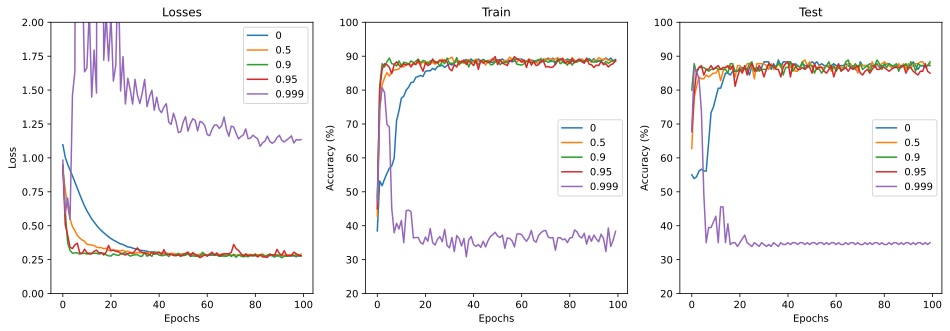

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
title = ['Losses', 'Train', 'Test']
for i in range(3):
    ax[i].plot(results[:, :, i])
    ax[i].legend(momenta)
    ax[i].set_xlabel('Epochs')
    ax[i].set_title(title[i])
    if i == 0:
        ax[i].set_ylabel('Loss')
        ax[i].set_ylim([0, 2])
    else:
        ax[i].set_ylabel('Accuracy (%)')
        ax[i].set_ylim([20, 100])

plt.show()